In [2]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
pip install emoji

## *Preparation and reading data*

In [3]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [5]:
df = rawToDf('WhatsApp Chat with CSE GIRLS💃🏼💫.txt', '12hr')
df

,date_time,user,message
0,2020-12-14 13:45:00,group_notification,Messages and calls are end-to-end encrypted. N...
1,2020-12-14 13:45:00,group_notification,"You created group ""THE CHOSEN ONES.......🤩"""
2,2020-12-14 13:46:00,Anonymous,Assalamualaikum tahiniyath and shaizeena
3,2020-12-14 13:46:00,Shaizeena,Walaikum assalam
4,2020-12-14 13:46:00,group_notification,"You changed the subject from ""THE CHOSEN ONES...."
...,...,...,...
24555,2023-07-11 13:11:00,Muffrah,Walekumassalam warahmatullahi wabarkatuhu
24556,2023-07-11 13:11:00,Muffrah,Alhamdulillah
24557,2023-07-11 13:11:00,Muffrah,SEMESTER 6 https://drive.google.com/drive/fold...
24558,2023-07-11 13:11:00,Tahiniyath,Jazakallhu khair


## Pre-Processing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24560 entries, 0 to 24559
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  24560 non-null  datetime64[ns]
 1   user       24560 non-null  object        
 2   message    24560 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 575.8+ KB


### The dataset contains 3 rows, and 13655 respective entries.
- Here is how it looks like:

In [7]:
df.sample(10)

,date_time,user,message
5027,2021-04-08 15:25:00,Iqra Sec B Mjcet,Ok
5046,2021-04-08 19:07:00,Maryam Khanita,Ok
1236,2021-02-14 23:54:00,Anonymous,Thats the only problem
23805,2023-05-01 18:27:00,Muffrah,Ameen
16445,2022-01-27 14:56:00,Tahiniyath,Bus program
467,2020-12-27 15:43:00,Tahiniyath,Rooz
1763,2021-02-16 14:48:00,Maliha Zia,B
15862,2022-01-20 19:41:00,Maryam Khanita,This message was deleted
21976,2022-10-30 21:44:00,Maryam Khanita,This message was deleted
5496,2021-04-09 15:09:00,Maryam Khanita,Na


In [8]:
df[df['message'] == ""].shape[0]

86

## Adding extra *helper columns for analysis and visualization*

In [9]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())
df['month_num'] = df['date'].dt.month


AttributeError: Can only use .dt accessor with datetimelike values

# Now that we have a clean DataFrame to work with, it’s time to perform analysis on it.
### Final Data Frame

In [10]:
df

,date_time,user,message,day,month,year,date
0,2020-12-14 13:45:00,group_notification,Messages and calls are end-to-end encrypted. N...,Mon,Dec,2020,2020-12-14
1,2020-12-14 13:45:00,group_notification,"You created group ""THE CHOSEN ONES.......🤩""",Mon,Dec,2020,2020-12-14
2,2020-12-14 13:46:00,Anonymous,Assalamualaikum tahiniyath and shaizeena,Mon,Dec,2020,2020-12-14
3,2020-12-14 13:46:00,Shaizeena,Walaikum assalam,Mon,Dec,2020,2020-12-14
4,2020-12-14 13:46:00,group_notification,"You changed the subject from ""THE CHOSEN ONES....",Mon,Dec,2020,2020-12-14
...,...,...,...,...,...,...,...
24555,2023-07-11 13:11:00,Muffrah,Walekumassalam warahmatullahi wabarkatuhu,Tue,Jul,2023,2023-07-11
24556,2023-07-11 13:11:00,Muffrah,Alhamdulillah,Tue,Jul,2023,2023-07-11
24557,2023-07-11 13:11:00,Muffrah,SEMESTER 6 https://drive.google.com/drive/fold...,Tue,Jul,2023,2023-07-11
24558,2023-07-11 13:11:00,Tahiniyath,Jazakallhu khair,Tue,Jul,2023,2023-07-11


In [11]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2020-12-14,197
1,2020-12-15,23
2,2020-12-16,20
3,2020-12-17,2
4,2020-12-18,46
...,...,...
576,2023-06-27,3
577,2023-06-29,17
578,2023-07-06,23
579,2023-07-07,1


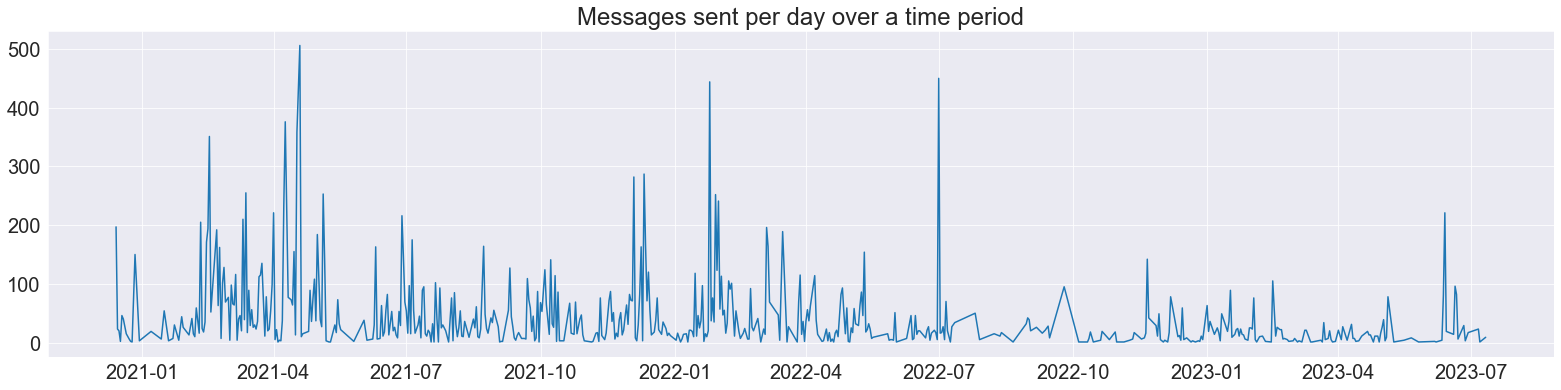

In [12]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('figure1.png')

# 2 *Top 10 most active days.*

In [13]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2021-04-19,506
1,2022-07-01,450
2,2022-01-25,444
3,2021-04-09,376
4,2021-04-17,358
5,2021-02-16,351
6,2021-12-11,287
7,2021-12-04,282
8,2021-03-13,255
9,2021-05-05,253


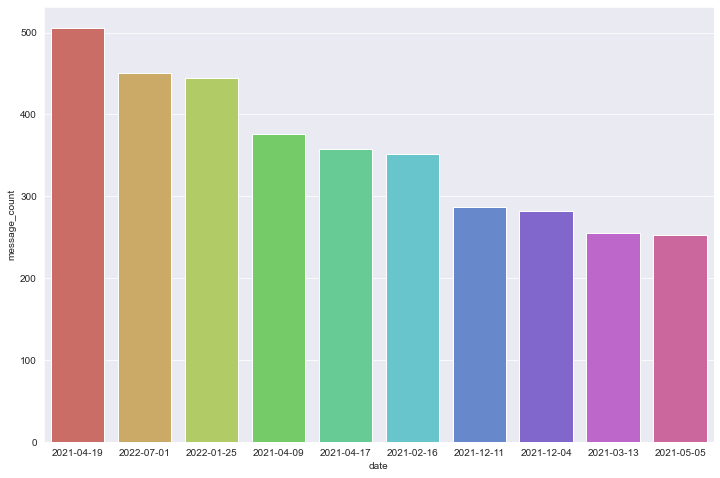

In [14]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(top10days.date, top10days.message_count, palette="hls");

# Saving the plots
plt.savefig('top10_days.png')

# 3. Top 10 active users on the group.

### Before, analysing that, we will see the *number of Ghosts* in the group.

In [15]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {13 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 16
Number of people who haven't sent even a single message on the group are -5


### *Shocking Result*
- Total number of people who have sent at least one message on the group are **154**.
- BUT, the total number of participants were **237**.
- **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**

## Now, pre-processing top 10 active users.

In [16]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,Anonymous,5569
1,Jahar,5299
2,Tahiniyath,4168
3,Maryam Khanita,3094
4,Iqra Sec B Mjcet,3076
5,Maliha Zia,911
6,Mariyam Arshia,735
7,Shaizeena,472
8,Muffrah,426
9,Sana,281


In [17]:
names = df2['user'].unique()
names

array(['Anonymous', 'Shaizeena', 'Tahiniyath', 'Maleha Sarwath Ansari',
       'Iqra Sec B Mjcet', 'Maryam Khanita', 'Jahar', 'Muffrah',
       'Mariyam Arshia', 'Zohra Fatima', 'Maliha Zia',
       'Zohra Mjcet Sec B', '+91 91828 62086', '+91 91213 73687', 'Sana',
       'Fatima'], dtype=object)

## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [18]:
top10df['initials'] = ''
for i in range(0,10):
    top10df.initials[i] = top10df.user[i].split()[0][0] 
#top10df.initials[8] = "me"    # That's me
#top10df.initials[9] = "DT"

In [19]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, I will be trying different visualization methods.*

##### Plotting a simple line graph.

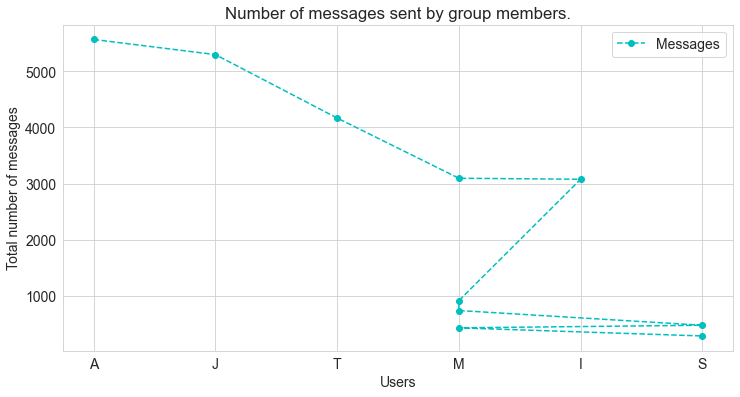

In [20]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
plt.savefig('msg_plots.png')

#### *Plotting a bar chart and line graph together.*

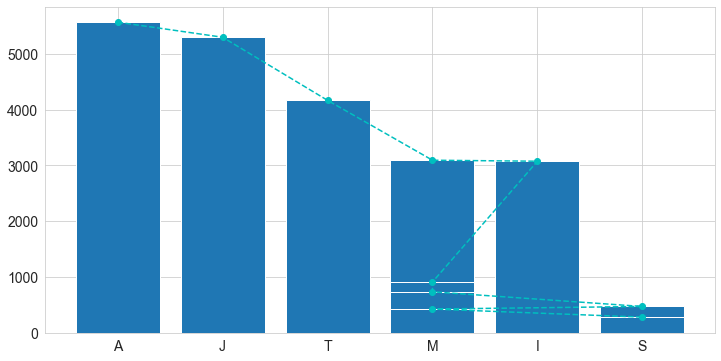

In [21]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart
plt.savefig('msg_plots.png')

### *Beautifying Default Styles using Seaborn*

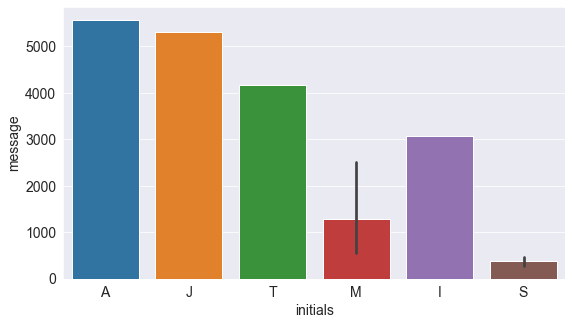

In [22]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(top10df.initials, top10df.message, data=top10df);
plt.savefig('output.png')

In [23]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'A': '#F94144',
 'J': '#F3722C',
 'T': '#F8961E',
 'M': '#6D597A',
 'I': '#F9C74F',
 'S': '#003F88'}

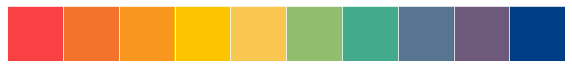

In [24]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)
plt.savefig('colors.png')# visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [25]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

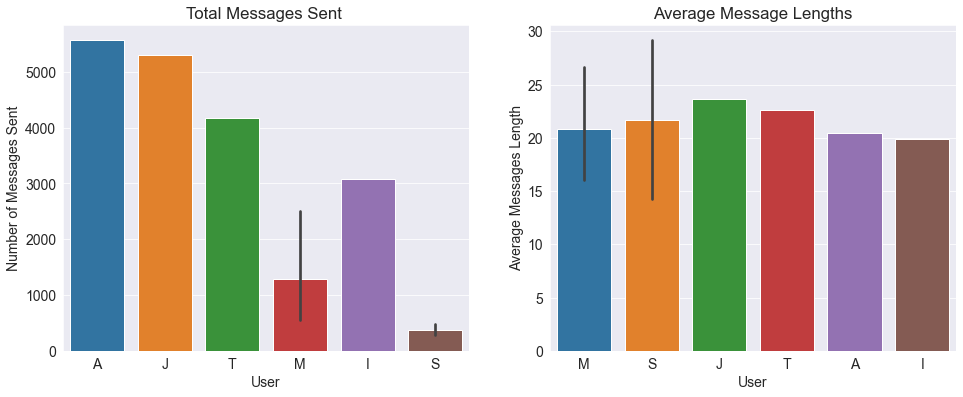

In [26]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(top10df.initials, top10df.message, data=top10df, ax = axes[0]);     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(top10df_msg.initials, top10df_msg.avg_message_length, ax = axes[1])    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.png')

# 4. Top 10 users most sent media 

- The exported chats were exported without any media files. Any message that contained media was indicated with `‘<Media Omitted> ’`. 

### *Pre-processing*
**We can use this to filter out and see who sends the most media.**

In [27]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0]
#top10media.initials[2] = "Me"    # That's me
#top10media.initials[9] = "VR"

###Which user sends the most media?

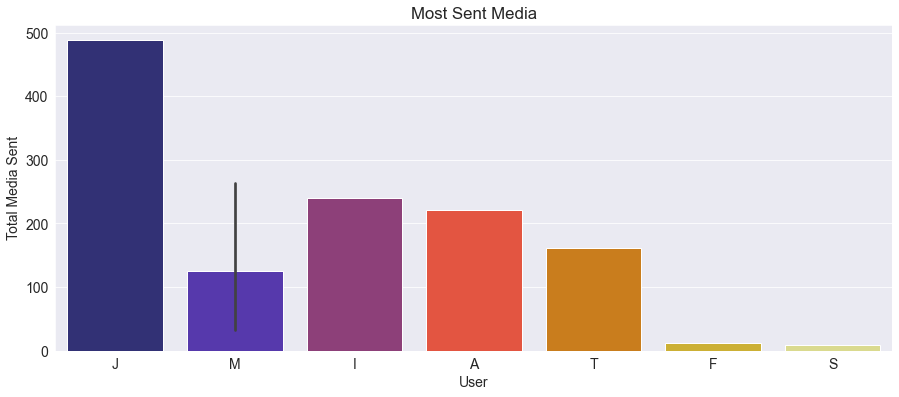

In [28]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(top10media.initials, top10media.media_sent, palette="CMRmap");

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.png', format = 'png')

### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [29]:
from collections import Counter

In [30]:
import re
from collections import Counter

emoji_ctr = Counter()
emojis_list = ["😀", "😃", "😄", "😁", "😆", "😅","😂","🤣","❤️","🙃","😭","😒"]  # Add more emojis to the list as needed
r = re.compile('|'.join(re.escape(p) for p in emojis_list))

for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [31]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,1360,face_with_tears_of_joy
1,😅,493,grinning_face_with_sweat
2,😭,343,loudly_crying_face
3,❤️,290,red_heart
4,🤣,161,rolling_on_the_floor_laughing
5,🙃,67,upside-down_face
6,😁,55,beaming_face_with_smiling_eyes
7,😀,14,grinning_face
8,😒,13,unamused_face
9,😆,12,grinning_squinting_face


### Which Emoji is the most used in the chat?

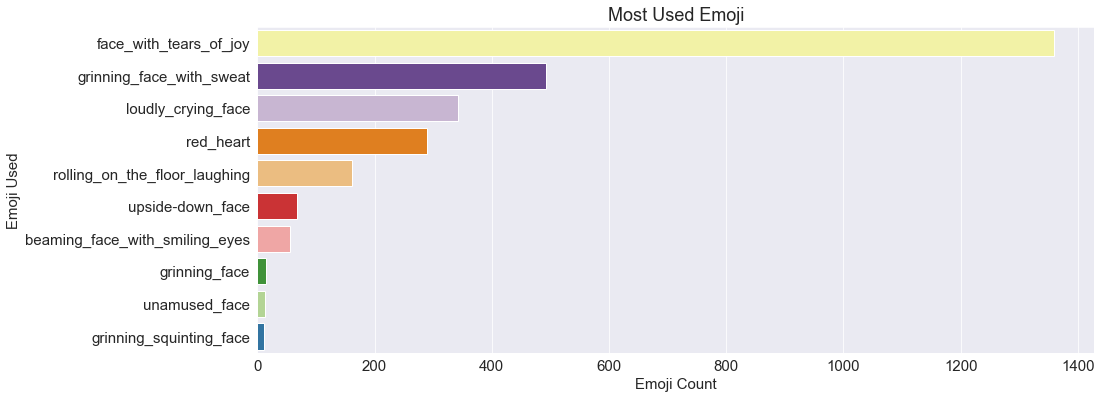

In [32]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 15

    # Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

    # Plotting;
sns.barplot(top10emojis.emoji_count, top10emojis.emoji_description, palette = "Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used');

    # Saving the plots
plt.savefig('top10emoji.png', format = 'png')

#### Not that it is worth anything, but "😂" beats everyone by a huge margin!

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [33]:
df3 = df.copy()


df3

,date_time,user,message,day,month,year,date,message_count,hour
0,2020-12-14 13:45:00,group_notification,Messages and calls are end-to-end encrypted. N...,Mon,Dec,2020,2020-12-14,1,13
1,2020-12-14 13:45:00,group_notification,"You created group ""THE CHOSEN ONES.......🤩""",Mon,Dec,2020,2020-12-14,1,13
2,2020-12-14 13:46:00,Anonymous,Assalamualaikum tahiniyath and shaizeena,Mon,Dec,2020,2020-12-14,1,13
3,2020-12-14 13:46:00,Shaizeena,Walaikum assalam,Mon,Dec,2020,2020-12-14,1,13
4,2020-12-14 13:46:00,group_notification,"You changed the subject from ""THE CHOSEN ONES....",Mon,Dec,2020,2020-12-14,1,13
...,...,...,...,...,...,...,...,...,...
24555,2023-07-11 13:11:00,Muffrah,Walekumassalam warahmatullahi wabarkatuhu,Tue,Jul,2023,2023-07-11,1,13
24556,2023-07-11 13:11:00,Muffrah,Alhamdulillah,Tue,Jul,2023,2023-07-11,1,13
24557,2023-07-11 13:11:00,Muffrah,SEMESTER 6 https://drive.google.com/drive/fold...,Tue,Jul,2023,2023-07-11,1,13
24558,2023-07-11 13:11:00,Tahiniyath,Jazakallhu khair,Tue,Jul,2023,2023-07-11,1,13


In [41]:
df3['message_count'] = [1] * df.shape[0]  
df3['message_count'].sum()
# helper column to keep a count.

24560

In [ ]:
df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

In [ ]:
grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

### Which hour of the day are most messages exchanged?

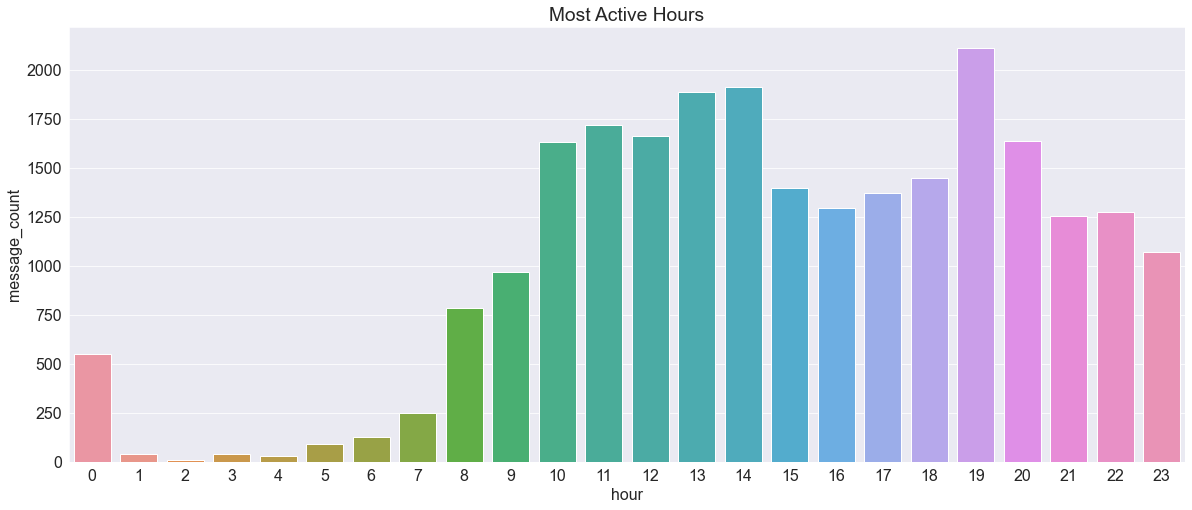

In [34]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

    # Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

    # PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours');

    # Saving the plots;
plt.savefig('most_active_hours.png')

### *Pre-processing weekdays and months*

In [35]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]


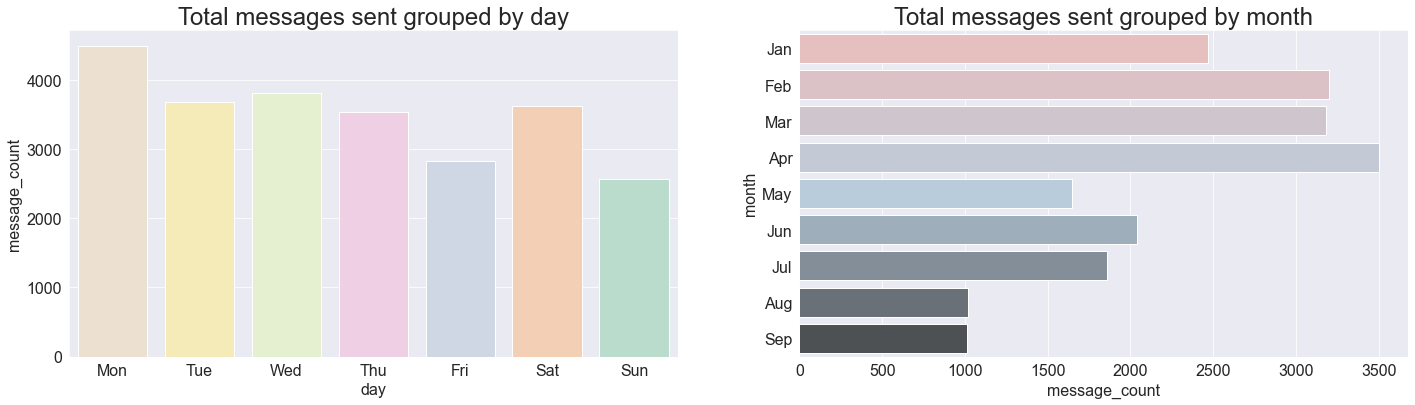

In [36]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(grouped_by_day.day, grouped_by_day.message_count, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.png')

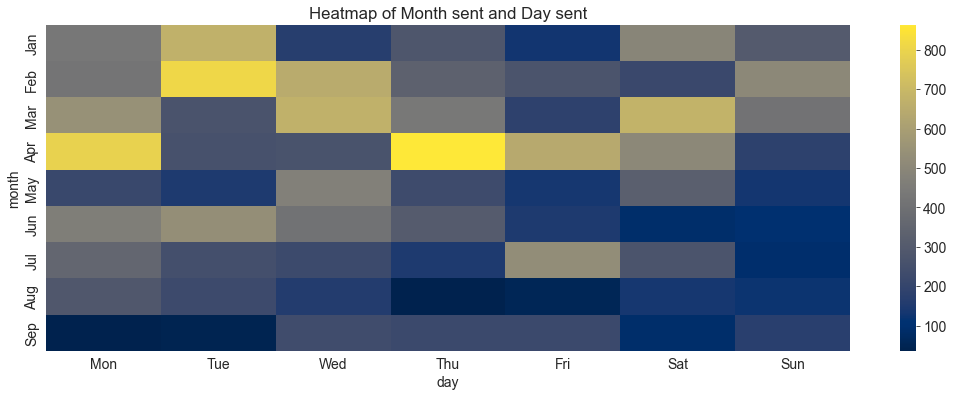

In [37]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.png')

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [38]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width=600, height=600, background_color='white', stopwords=stopwords, min_font_size=8).generate(comment_words)


ValueError: Only supported for TrueType fonts

In [ ]:
wordcloud.to_image()

In [ ]:
wordcloud = WordCloud(width=600, height=600, background_color='white', stopwords=stopwords, min_font_size=8).generate(comment_words)

In [ ]:
wordcloud = WordCloud(background_color="white",stopwords = stopwords, font_path="Godshomedemo-K794e.ttf").generate(comment_words)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
wordmap = {}
for message in df['message']:
    dummy = message.split()
    for word in dummy:
        if word in wordmap:
            wordmap[word]+=1
            
        else:
            wordmap[word] = 1
            
            
wordmap = dict(sorted(wordmap.items(),key = lambda x:x[1],reverse = True))

wordmap

In [ ]:
from collections import Counter
words = []
for message in df['message']:
    words.extend(message.split())
    
wordmap = dict(Counter(words).most_common(20))
wordmap = dict(sorted(wordmap.items(),key=lambda x:x[1],reverse=True))
newdf = pd.DataFrame(wordmap.items())
newdf